In [42]:
from tree_sitter_languages import get_parser

parser = get_parser("python")
tree = parser.parse(bytes("def foo():\n    pass", "utf8"))
root = tree.root_node

In [43]:
root.sexp()

'(module (function_definition name: (identifier) parameters: (parameters) body: (block (pass_statement))))'

In [44]:
import networkx as nx
import tree_sitter

# Filtering for anon nodes is necessary to avoid a lot of noise and non important features??
def tree_to_graph(root: tree_sitter.Node, with_anon: bool = False) -> nx.DiGraph:
    G = nx.DiGraph()
    todo = [root]
    while todo:
        node = todo.pop()
        if with_anon or node.is_named:
            G.add_node(node.id, type=node.type)
        for child in node.children:
            if with_anon or child.is_named:
                G.add_edge(node.id, child.id)
            todo.append(child)
    return G

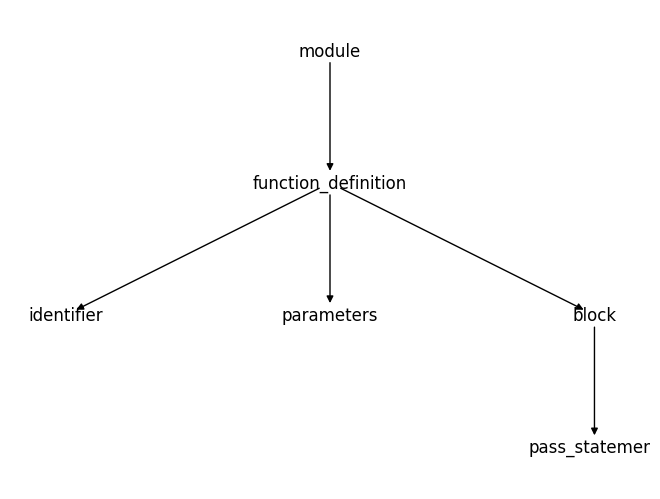

In [45]:
T = tree_to_graph(root)
labels = nx.get_node_attributes(T, "type")
pos = nx.nx_agraph.graphviz_layout(T, prog="dot")
nx.draw(T, pos, labels=labels, node_color="none")

In [46]:
from pathlib import Path
import pickle

def save_graph_to_pickle(graph: nx.Graph, path: Path):
    with open(path, "wb") as f:
        pickle.dump(graph, f)

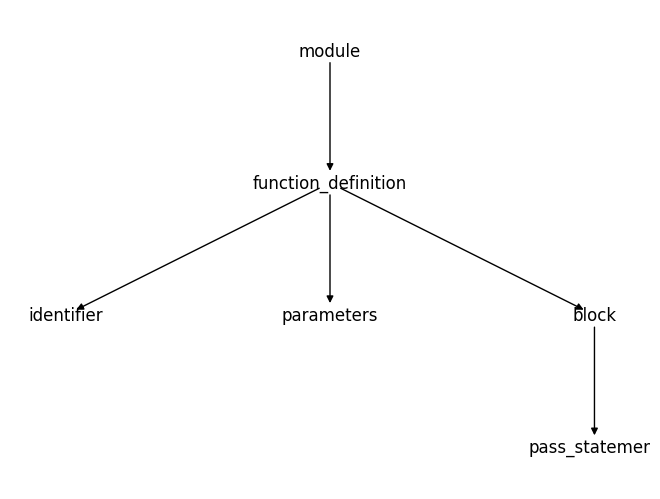

In [37]:
import pickle

with open("test_tree.pickle", "wb") as f:
    pickle.dump(T, f)

with open("test_tree.pickle", "rb") as f:
    T = pickle.load(f)

nx.draw(T, pos, labels=labels, node_color="none")

In [47]:
from function_pipes import pipe
from pathlib import Path

parser = get_parser("python")

def read_bytes(path: Path) -> bytes:
    with open(path, "rb") as f:
        return f.read()

def get_tree_from_code(code: bytes) -> nx.DiGraph:
    return pipe(code, parser.parse, lambda tree: tree.root_node, tree_to_graph)



In [1]:
# featurization from blob
from requests import get

blob_link = "https://api.github.com/repos/3b1b/manim/git/blobs/127e438d07fe8c53357fd84368652c81124fc06b"
response = get(blob_link)
response

<Response [200]>

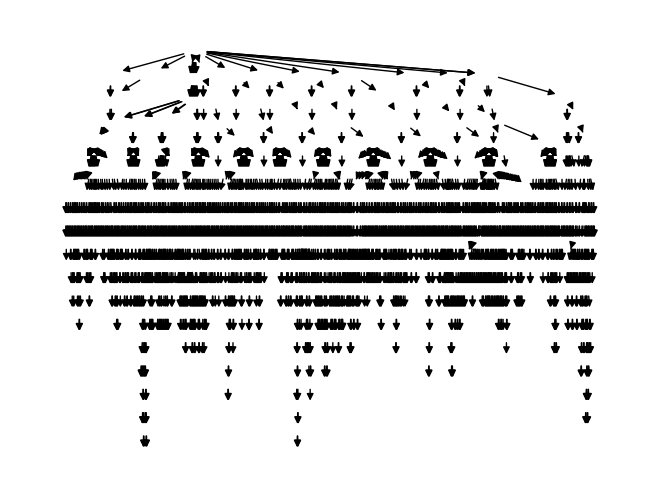

In [10]:
import base64

j = response.json()
code = base64.b64decode(j["content"])
tree = get_tree_from_code(code)
labels = nx.get_node_attributes(tree, "type")
pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
nx.draw(tree, pos, node_color="none")

In [11]:
import pickle

with open("one_blob.pickle", "wb") as f:
    pickle.dump(tree, f)

In [2]:
# commit featurization pipeline
from definitions import REPO_DIR
import json
from masters_thesis.helper import api_get

specific_repo = REPO_DIR / "3b1b/manim"
with open (specific_repo / "repo.json") as f:
    repo_json = json.load(open(specific_repo / "repo.json"))
commits = list(api_get(repo_json['commits_url'].format(**{"/sha": "?per_page=100"})))
with open(specific_repo / "commits.json", "w") as f:
    json.dump(commits, f, indent=4)

In [9]:
from masters_thesis.helper import flatten
all_commits = flatten([response['items'] for response in commits])
# all_commits[0]

In [11]:
commits_dir = specific_repo / "commits"
commits_dir.mkdir(exist_ok=True)


In [14]:
all_commits[0]

{'sha': 'd8428585f84681055fed8aa3fabfb6ae95e4a0ff',
 'node_id': 'C_kwDOAfLOx9oAKGQ4NDI4NTg1Zjg0NjgxMDU1ZmVkOGFhM2ZhYmZiNmFlOTVlNGEwZmY',
 'commit': {'author': {'name': 'Grant Sanderson',
   'email': 'grant@3blue1brown.com',
   'date': '2023-02-15T17:40:43Z'},
  'committer': {'name': 'GitHub',
   'email': 'noreply@github.com',
   'date': '2023-02-15T17:40:43Z'},
  'message': 'Merge pull request #1994 from 3b1b/video-work\n\nSeveral bug fixes',
  'tree': {'sha': 'a2c7aee2d7acc255d5ff9f6e5f3be47fb0677221',
   'url': 'https://api.github.com/repos/3b1b/manim/git/trees/a2c7aee2d7acc255d5ff9f6e5f3be47fb0677221'},
  'url': 'https://api.github.com/repos/3b1b/manim/git/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff',
  'comment_count': 0,
  'verification': {'verified': True,
   'reason': 'valid',
   'signature': '-----BEGIN PGP SIGNATURE-----\n\nwsBcBAABCAAQBQJj7RkbCRBK7hj4Ov3rIwAAoTwIAEb8eyfVUCpjtEr9kV0PWxZs\nDsEtHcp+gzXvpnmzUKUBx8GoOISNLyUSPlYXC2RSlVy9AV0TXDUWbIDBByI7o6/H\nnQfFTxe4BygGNI3HIE

In [59]:
from typing import Any
from uuid6 import uuid7
import base64
import pickle
import json
from typing import Iterator


def handle_git_tree(
    git_tree: dict[str, str], path: str = ""
) -> Iterator[tuple[dict[str, Any], str]]:
    for item in git_tree["tree"]:
        if item["type"] == "tree":
            tree = next(api_get(item["url"]))
            yield from handle_git_tree(tree, path + item["path"] + "/")
        if item["type"] == "blob":
            blob = next(api_get(item["url"]))
            yield blob, path + item["path"]


def handle_commit(commit: dict[str, Any], save_files: bool = False) -> None:
    sha = commit["sha"]
    commit_dir = commits_dir / sha
    commit_dir.mkdir(exist_ok=True)
    with open(commit_dir / "commit.json", "w") as f:
        json.dump(commit, f, indent=4)
    git_tree = commit["commit"]["tree"]["url"]
    tree = next(api_get(git_tree))
    with open(commit_dir / "tree.json", "w") as f:
        json.dump(tree, f, indent=4)
    file_dir = commit_dir / "files"
    file_dir.mkdir(exist_ok=True)
    featurized_dir = commit_dir / "featurized"
    featurized_dir.mkdir(exist_ok=True)
    for item, path in handle_git_tree(tree):
        if save_files:
            item_path = file_dir / (path + ".json")
            item_path.parent.mkdir(exist_ok=True, parents=True)
            with open(item_path, "w") as f:
                json.dump(item, f, indent=4)
        if path.endswith(".py"):
            uuid = uuid7().hex
            code = base64.b64decode(item["content"])
            tree = get_tree_from_code(code)
            tree_path = featurized_dir / (uuid + ".pickle")
            with open(tree_path, "wb") as f:
                pickle.dump(tree, f)
            with open(featurized_dir / (uuid + ".json"), "w") as f:
                json.dump({"path": path, "file_size": item["size"]}, f, indent=4)


handle_commit(all_commits[0])

{'path': 'manimlib/utils/sounds.py', 'file_size': 328}


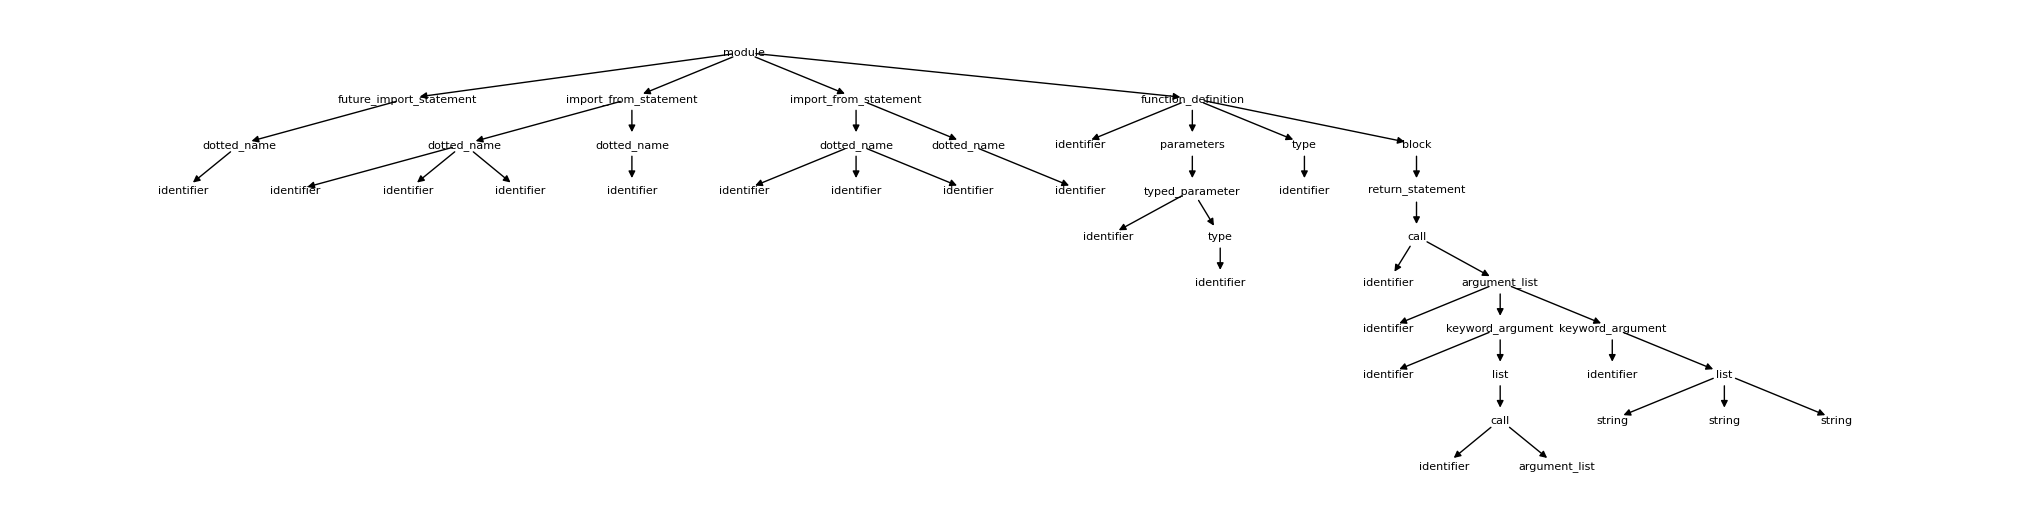

In [9]:
import pickle
import json
from function_pipes import pipe
from os.path import splitext
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any
import networkx as nx


def read_json(path: Path) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def read_pickle(path: Path) -> Any:
    with open(path, "rb") as f:
        return pickle.load(f)


featurized_dir = Path(
    "/home/fox/Projects/learning-portfolio/university/masters/masters-thesis/data/repos/3b1b/manim/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff/featurized"
)
items = [
    {"metadata": read_json(item), "tree": read_pickle(item.with_suffix(".pickle"))}
    for item in featurized_dir.iterdir()
    if item.suffix == ".json"
]

items.sort(key = lambda item: item["metadata"]["file_size"])
index = 10
print(items[index]["metadata"])
labels = nx.get_node_attributes(items[index]['tree'], "type")
pos = nx.nx_agraph.graphviz_layout(items[index]['tree'], prog="dot")
fig = plt.figure(1, figsize=(20, 5))
nx.draw(items[index]['tree'], pos, node_color="none", labels=labels, font_size=8)

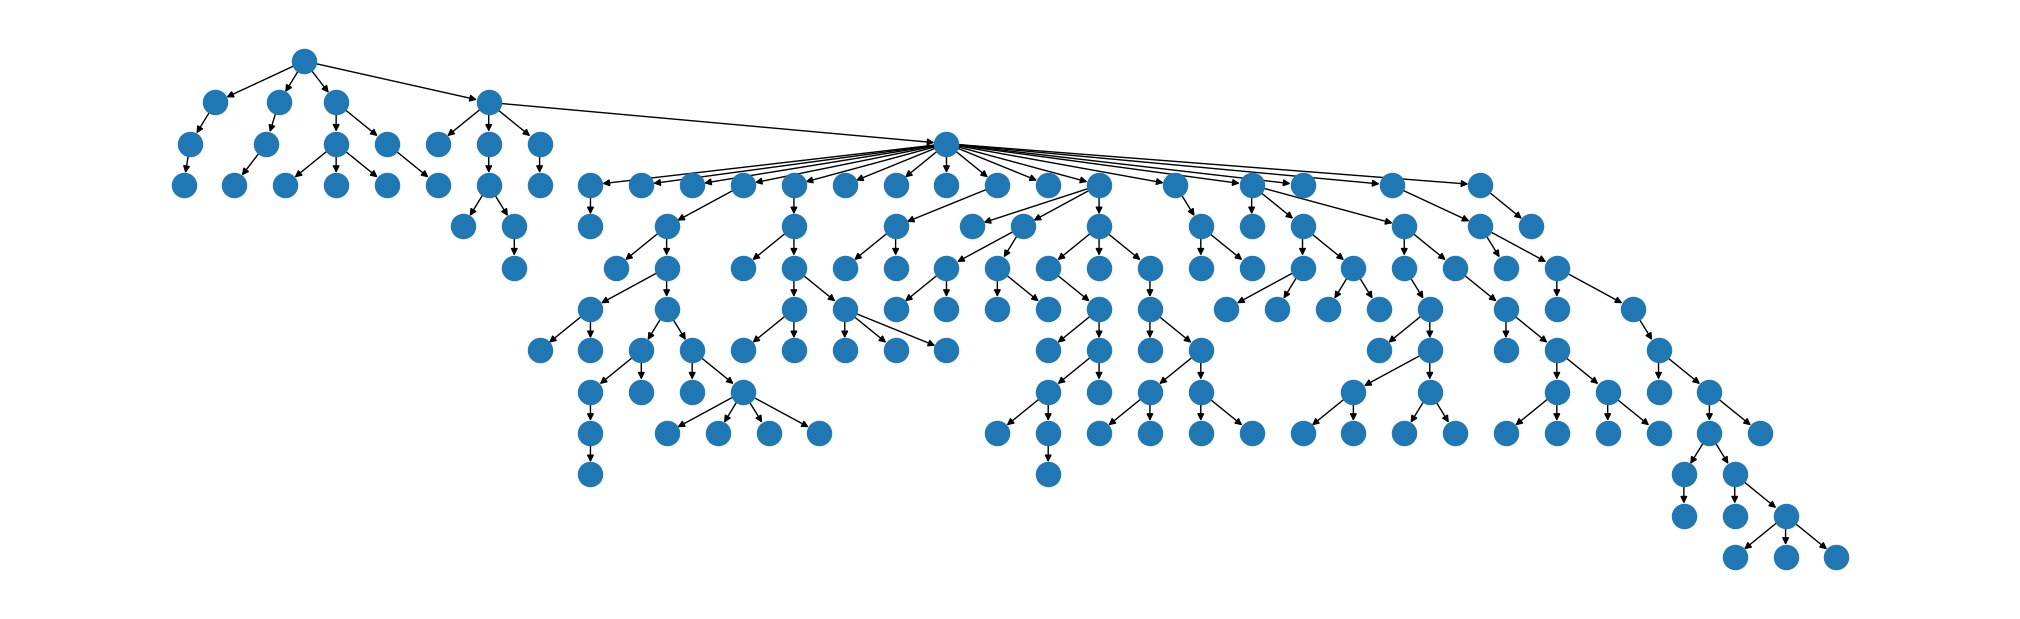

In [93]:
fig = plt.figure(1, figsize=(20, 6))
nx.draw(items[index]['tree'], pos)

In [88]:
with open("/home/fox/Projects/learning-portfolio/university/masters/masters-thesis/data/repos/3b1b/manim/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff/files/manimlib/utils/sounds.py.json", "r") as f:
    item = json.load(f)

code = base64.b64decode(item["content"])
code
with open("example_code.py", "wb") as f:
    f.write(code)